## Initial Setup 
Import modules, load weights from pre-trained FCN, and set hyperparameters

In [2]:
import numpy as np 
import cvxpy
import matplotlib.pyplot as plt

import nengo 
from nengo.dists import Choice 
from nengo.utils.ensemble import tuning_curves
from nengo.utils.matplotlib import rasterplot
from nengo.neurons import Direct

import tensorflow as tf
import gym
import pickle
import cvxpy 

import pdb

In [3]:
dnn_weights = pickle.load(open('./Weights/DNN_weights.p', 'rb'))
dnn_layers = len(dnn_weights)
dnn_activations = pickle.load(open('./Weights/activations.p', 'rb'))

INPUT_DIMS = 4
OUTPUT_DIMS = 2
h = 64
T_INT = 0.50
CLOCK = 1000.0 #Hz 
GAIN = 1.0
N_EPISODES = 5

## Tensorflow Model 
We'll build the DNN here using the previously learned weights to compare with our SNN. We'll also setup our environment model 

In [4]:
tf_model = {}
with tf.variable_scope('layer_one',reuse=False):
    xavier_l1 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(INPUT_DIMS), dtype=tf.float32)
    tf_model['W1'] = tf.get_variable("W1", [INPUT_DIMS, h], initializer=xavier_l1)
with tf.variable_scope('layer_two',reuse=False):
    xavier_l2 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(h), dtype=tf.float32)
    tf_model['W2'] = tf.get_variable("W2", [h,h], initializer=xavier_l2)
with tf.variable_scope('layer_1',reuse=False):
    xavier_l3 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(h), dtype=tf.float32)
    tf_model['W3'] = tf.get_variable("W3", [h,OUTPUT_DIMS], initializer=xavier_l3)

In [5]:
def tf_policy_forward(x): #x ~ [1,D]
    h = tf.matmul(x, tf_model['W1'])
    h = tf.nn.relu(h)
    h = tf.matmul(h, tf_model['W2'])
    h = tf.nn.relu(h)
#     p = tf.matmul(h, tf_model['W3'])
    logp = tf.matmul(h, tf_model['W3'])
    p = tf.nn.softmax(logp)
    return p #normalized logits

def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

tf_x = tf.placeholder(dtype=tf.float32, shape=[None, INPUT_DIMS],name="tf_x")
tf_aprob = tf_policy_forward(tf_x)

saver = tf.train.Saver()
sess = tf.InteractiveSession()
saver.restore(sess, './Weights/weights')

env = gym.make('CartPole-v0')


[2017-05-07 12:53:32,749] Making new env: CartPole-v0


## Weight Normalization 
Using Data-based normalization (Diehl et al), scale weights based on maximum activation and maximum weight per-layer. Maximum input to a neuron should result in a rate of no more than the clock rate. 

In [6]:
previous_factor = 1.0
scaled_weights = []
for layer, weight in enumerate(dnn_weights[:2]):
    max_act = np.amax(dnn_activations[layer])
    max_wt = np.amax(weight)
    scale_factor = np.max((max_act, max_wt))/GAIN
    applied_factor = scale_factor/previous_factor
    scaled_weights.append(weight/applied_factor)
    previous_factor = scale_factor 
scaled_weights.append(dnn_weights[2]*previous_factor)

In [7]:
m = 2**4
C = np.zeros((m,4))
for i in range(m):
    for j in range(4):
        C[i, j] = np.round(np.mod(i*(2**j),m)/m+0.0001)

discrete_weights_ =[]
for layer, weight in enumerate(scaled_weights):
    m = int(weight.shape[0]*4)
    weight_d = np.zeros([m, weight.shape[1]])
    for neuron in range(weight.shape[1]):
        W = weight[:, neuron]
        W = np.reshape(W, (-1,1))*10
        W_ = np.round(W)
        Wu = np.unique(W_)

        coverage = np.zeros([len(Wu),len(Wu),len(Wu),len(Wu)])
        max_count = 2

        for i in Wu:
            for j in Wu:
                for k in Wu:
                    for l in Wu: 
                        s = np.array([i, j, k, l]).T
                        x = C.dot(s)                    
                        count = len(set(x) & set(Wu))
                        if count > max_count: 
                            S = s
                            max_count = count 
                        if max_count == len(Wu):
                            break
                    if max_count == len(Wu):
                        break
            if max_count == len(Wu):
                break
                
        result = np.zeros([len(W_), 4])
        for i, w in enumerate(W_): 
            loss = (C.dot(S)-w)**2
            idx = np.argmin(loss)
            result[i,:] = C[idx,:] 
        
        c_ = np.reshape(result, (-1,1), order='F')
        c_[:int(m/4)] = c_[:int(m/4)]*S[0]
        c_[int(m/4):int(m/2)] = c_[int(m/4):int(m/2)]*S[1]
        c_[int(m/2):int(3*m/4)] = c_[int(m/2):int(3*m/4)]*S[2]
        c_[int(3*m/4):int(m)] = c_[int(3*m/4):int(m)]*S[3]

        weight_d[:, neuron] = c_.squeeze()   
    discrete_weights_.append(weight_d)

m = len(discrete_weights_)
discrete_weights = []
for weight in discrete_weights_[:m]:
    weight_ = np.hstack((weight,weight,weight,weight))
    discrete_weights.append(weight_)

    

In [8]:

W = scaled_weights[0]*10
W_d_ = discrete_weights_[0]
A = np.hstack([np.eye(W.shape[0]),np.eye(W.shape[0]),np.eye(W.shape[0]),np.eye(W.shape[0])])
W_e = A.dot(W_d_)
W_l = (W - W_e)**2
loss = W_l.mean()
print(loss)

0.0806327574225


## Weight Distribution 
We plot the weights of each layer for inspection. Notice the majority of weights are near zero. This will mainfest as sparsity in the spike trains later

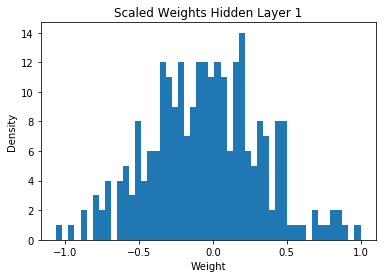

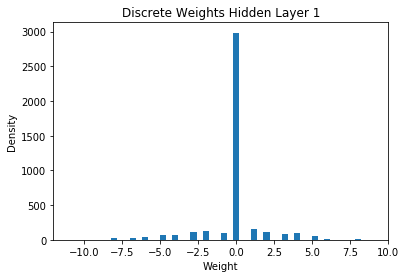

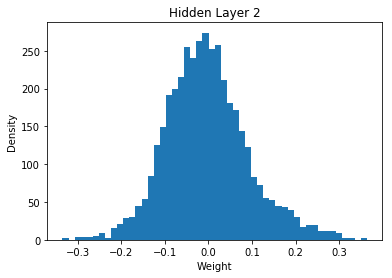

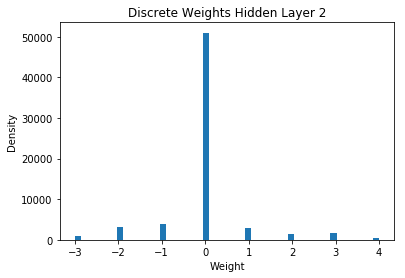

In [18]:
plt.hist(scaled_weights[0].flatten(), bins= 50)
plt.xlabel('Weight')
plt.ylabel('Density')
plt.title('Scaled Weights Hidden Layer 1')
plt.show()

plt.hist(discrete_weights[0].flatten(), bins= 50)
plt.xlabel('Weight')
plt.ylabel('Density')
plt.title('Discrete Weights Hidden Layer 1')
plt.show()

plt.figure()
plt.hist(scaled_weights[1].flatten(), bins= 50)
plt.xlabel('Weight')
plt.ylabel('Density')
plt.title('Hidden Layer 2')
plt.show()

plt.hist(discrete_weights[1].flatten(), bins= 50)
plt.xlabel('Weight')
plt.ylabel('Density')
plt.title('Discrete Weights Hidden Layer 2')
plt.show()

## ReLU Network
We'll build a network using the scaled weights calculated previously and ReLU neurons to validate the weight scaling. 

In [19]:
model = nengo.Network()

model_layers = {}
with model: 
    for layer, weight in enumerate(scaled_weights):
        no_neuron = weight.shape[1]
        model_layers[layer] = nengo.Ensemble(no_neuron, 
                                             dimensions=no_neuron,
                                             neuron_type = nengo.RectifiedLinear(),
                                             encoders= np.eye(no_neuron),
                                             max_rates = np.zeros([no_neuron,]) + 1.0,
                                             intercepts = np.zeros([no_neuron,])
                                             )
    model_layers[0].label = 'Layer 1'
    model_layers[1].label = 'Layer 2'
    model_layers[2].label = 'Layer 3' #Not in use 
    
    input_node = nengo.Node(lambda t: observation, size_out=INPUT_DIMS) 
    nengo.Connection(input_node, model_layers[0], 
                     transform=scaled_weights[0].transpose(),
                    synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    nengo.Connection(model_layers[0].neurons, model_layers[1], 
                     transform=scaled_weights[1].transpose(),
                    synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    nengo.Connection(model_layers[1].neurons, model_layers[2], 
                     transform=scaled_weights[2].transpose(),
                    synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    
    Probe_In = nengo.Probe(input_node)
    Probe_A1 = nengo.Probe(model_layers[2].neurons[0], synapse = 0.01)
    Probe_A2 = nengo.Probe(model_layers[2].neurons[1], synapse = 0.01)
    Probe = nengo.Probe(model_layers[0].neurons)
    Probe_in2 = nengo.Probe(model_layers[1], 'input')
    Spikes_1 = nengo.Probe(model_layers[0].neurons)
    Spikes_2 = nengo.Probe(model_layers[1].neurons, synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    Spikes_3 = nengo.Probe(model_layers[2].neurons)

In [167]:
error = []
epsd_error = []
for epsd in range(N_EPISODES):
    observation = env.reset()
    done = False
    epsd_err = []
    while not done:
        x = observation
        feed = {tf_x: np.reshape(x, (1,-1))}
        aprob = sess.run(tf_aprob,feed)
        dnn_aprob = aprob[0,:]      
        with nengo.Simulator(model) as sim:
            sim.run(0.15, progress_bar=False)
        h_out = sim.data[Spikes_1]
        out_enc = sim.data[Spikes_2]
        out_dec = np.dot(out_enc,scaled_weights[2])
        n = out_dec.shape[0]
        out_1 = out_dec[n-100:,0].mean()
        out_2 = out_dec[n-100:,1].mean()
        snn_aprob = softmax([out_1,out_2])
        action = np.random.choice(OUTPUT_DIMS, p=snn_aprob)
        observation, reward, done, info = env.step(action)
        err = dnn_aprob[0]-snn_aprob[0]
        error.append(err)
        epsd_err.append(err)
    if not epsd % 1:
        print('Episode %r complete' % (epsd+1))
    eps_RMSE = np.sqrt(np.mean(np.array(epsd_err)**2))
    epsd_error.append(eps_RMSE)

Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                              

RMSE is 3.0256011697728345e-08


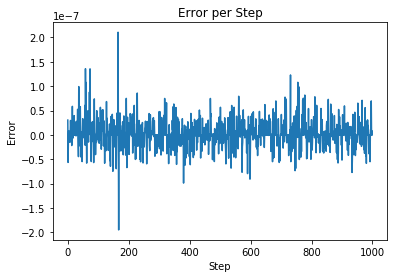

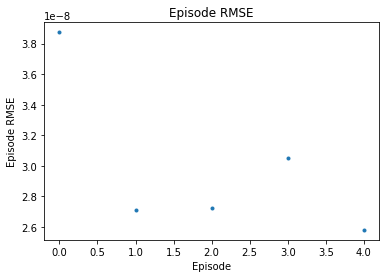

In [168]:
RMSE = np.sqrt(np.mean(np.array(error)**2))
print('RMSE is %r' % RMSE)

plt.figure()
plt.plot(error)
plt.xlabel('Step')
plt.ylabel('Error')
plt.title('Error per Step')
plt.figure()
plt.plot(epsd_error, '.')
plt.xlabel('Episode')
plt.ylabel('Episode RMSE')
plt.title('Episode RMSE')
plt.show()

In [58]:
model = nengo.Network()

model_layers = {}
with model: 
    for layer, weight in enumerate(discrete_weights):
        no_neuron = weight.shape[1]
        model_layers[layer] = nengo.Ensemble(no_neuron, 
                                             dimensions=no_neuron,
                                             neuron_type = nengo.RectifiedLinear(),
                                             encoders= np.eye(no_neuron),
                                             gain = np.zeros([no_neuron,]) + 1.0,
                                             bias = np.zeros([no_neuron,])
                                             )
    model_layers[0].label = 'Layer 1'
    model_layers[1].label = 'Layer 2'
    model_layers[2].label = 'Layer 3' #Not in use 
    
    input_node = nengo.Node(lambda t: 0.001*np.hstack((observation, observation, observation, observation)),
                            size_out=INPUT_DIMS*4) 
    nengo.Connection(input_node, model_layers[0], 
                     transform=discrete_weights[0].transpose(),
                    synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    nengo.Connection(model_layers[0].neurons, model_layers[1], 
                     transform=discrete_weights[1].transpose(),
                    synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    nengo.Connection(model_layers[1].neurons, model_layers[2], 
                     transform=discrete_weights[2].transpose(),
                    synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    
    Probe_In = nengo.Probe(input_node)
    Probe_A1 = nengo.Probe(model_layers[2].neurons[0], synapse = 0.01)
    Probe_A2 = nengo.Probe(model_layers[2].neurons[1], synapse = 0.01)
    Probe = nengo.Probe(model_layers[0].neurons)
    Probe_in2 = nengo.Probe(model_layers[1], 'input')
    Spikes_1 = nengo.Probe(model_layers[0].neurons)
    Spikes_2 = nengo.Probe(model_layers[1].neurons, synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    Spikes_3 = nengo.Probe(model_layers[2].neurons)

(16,)
Building finished in 0:00:01.                                                                       
Simulating finished in 0:00:01.                                                                     
Observation: array([-0.0093271 , -0.03704115,  0.01319369,  0.01825887])
dnn: array([ 0.48300019,  0.51699984], dtype=float32)
snn: array([ 0.49616795,  0.50383205])


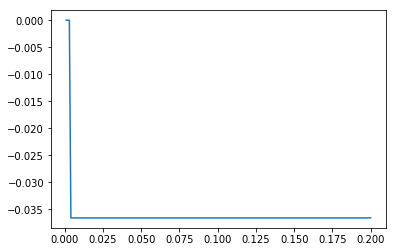

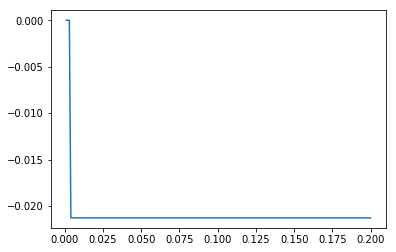

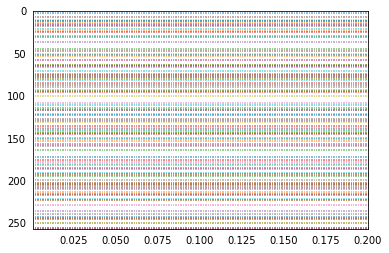

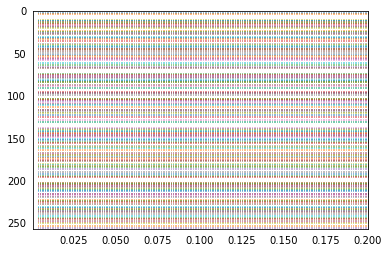

In [59]:
observation = env.reset()
print(np.hstack((observation, observation, observation, observation)).shape)
x = observation
feed = {tf_x: np.reshape(x, (1,-1))}
aprob = sess.run(tf_aprob,feed)
dnn_aprob = aprob[0,:]      

T = 0.2
with nengo.Simulator(model) as sim:
    sim.run(T)
h_out = sim.data[Spikes_1]
out_enc = sim.data[Spikes_2]
out_dec = np.dot(out_enc,discrete_weights[2])
n = out_dec.shape[0]
interval = int(T_INT*1000.00*0.7)
out_1 = out_dec[n-interval:,0].mean()
out_2 = out_dec[n-interval:,1].mean()

snn_aprob = softmax([out_1,out_2])
print('Observation: %r' % observation)
print('dnn: %r' % dnn_aprob)
print('snn: %r' % snn_aprob)

plt.close()
plt.plot(sim.trange(), out_dec[:,0])

plt.figure()
plt.plot(sim.trange(), out_dec[:,1])

plt.show()

In [60]:
error = []
epsd_error = []
for epsd in range(N_EPISODES):
    observation = env.reset()
    done = False
    epsd_err = []
    while not done:
        x = observation
        feed = {tf_x: np.reshape(x, (1,-1))}
        aprob = sess.run(tf_aprob,feed)
        dnn_aprob = aprob[0,:]      
        with nengo.Simulator(model) as sim:
            sim.run(0.15, progress_bar=False)
        h_out = sim.data[Spikes_1]
        out_enc = sim.data[Spikes_2]
        out_dec = np.dot(out_enc,discrete_weights[2])
        n = out_dec.shape[0]
        out_1 = out_dec[n-100:,0].mean()
        out_2 = out_dec[n-100:,1].mean()
        snn_aprob = softmax([out_1,out_2])
        action = np.random.choice(OUTPUT_DIMS, p=snn_aprob)
        observation, reward, done, info = env.step(action)
        err = dnn_aprob[0]-snn_aprob[0]
        error.append(err)
        epsd_err.append(err)
    if not epsd % 1:
        print('Episode %r complete' % (epsd+1))
    eps_RMSE = np.sqrt(np.mean(np.array(epsd_err)**2))
    epsd_error.append(eps_RMSE)

Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                              

RMSE is 0.091690428016315606


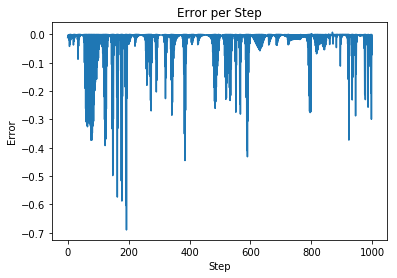

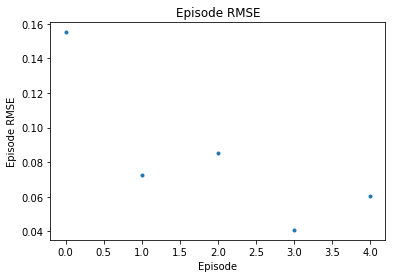

In [61]:
RMSE = np.sqrt(np.mean(np.array(error)**2))
print('RMSE is %r' % RMSE)

plt.figure()
plt.plot(error)
plt.xlabel('Step')
plt.ylabel('Error')
plt.title('Error per Step')
plt.figure()
plt.plot(epsd_error, '.')
plt.xlabel('Episode')
plt.ylabel('Episode RMSE')
plt.title('Episode RMSE')
plt.show()

## Digital Network 
Now we'll build a network of digital neurons using the custom TrueNorth neuron type. We will still use constant inputs and 32-bit weights. 

In [142]:
model = nengo.Network()

model_layers = {}
with model: 
    for layer, weight in enumerate(discrete_weights):
        no_neuron = weight.shape[1]
        model_layers[layer] = nengo.Ensemble(no_neuron, 
                                             dimensions=no_neuron,
                                             neuron_type = nengo.neurons.TrueNorth(alpha=GAIN*10),
                                             encoders= np.eye(no_neuron),
                                             gain = np.zeros([no_neuron,]) + 1.0,
                                             bias = np.zeros([no_neuron,])
                                                                 )
    model_layers[0].label = 'Layer 1'
    model_layers[1].label = 'Layer 2'
    model_layers[2].label = 'Layer 3' #Not in use 
    
    input_node = nengo.Node(lambda t: 0.1*np.hstack((observation, observation, observation, observation)),
                            size_out=INPUT_DIMS*4)
    nengo.Connection(input_node, model_layers[0], 
                     transform=discrete_weights[0].transpose(),
                    synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    nengo.Connection(model_layers[0].neurons, model_layers[1], 
                     transform=discrete_weights[1].transpose(),
                    synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    nengo.Connection(model_layers[1].neurons, model_layers[2], 
                     transform=discrete_weights[2].transpose(),
                    synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    
    Probe_In = nengo.Probe(input_node)
    Probe_A1 = nengo.Probe(model_layers[2].neurons[0], synapse = 0.01)
    Probe_A2 = nengo.Probe(model_layers[2].neurons[1], synapse = 0.01)
    Probe = nengo.Probe(model_layers[0].neurons)
    Probe_in2 = nengo.Probe(model_layers[1], 'input')
    Spikes_1 = nengo.Probe(model_layers[0].neurons)
    Spikes_2 = nengo.Probe(model_layers[1].neurons, synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    Spikes_3 = nengo.Probe(model_layers[2].neurons)

Building finished in 0:00:01.                                                                       
Simulating finished in 0:00:01.                                                                     
Observation: array([-0.04715522, -0.03583087,  0.04011166,  0.04427902])
dnn: array([ 0.20098978,  0.79901016], dtype=float32)
snn: array([ 0.23527702,  0.76472298])


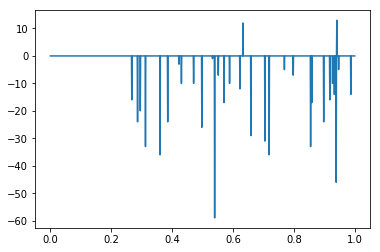

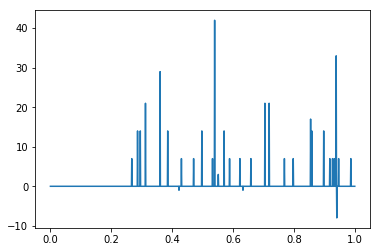

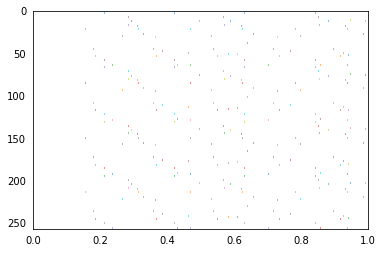

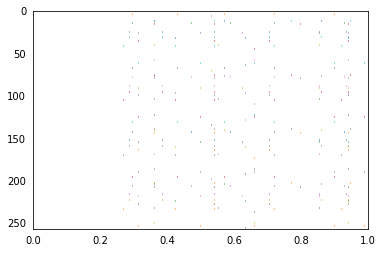

In [145]:
observation = env.reset()
x = observation
feed = {tf_x: np.reshape(x, (1,-1))}
aprob = sess.run(tf_aprob,feed)
dnn_aprob = aprob[0,:]      

T = 1.0
with nengo.Simulator(model) as sim:
    sim.run(T)
h_out = sim.data[Spikes_1]
out_enc = sim.data[Spikes_2]
out_dec = np.dot(out_enc,discrete_weights[2])
n = out_dec.shape[0]
# interval = int(T_INT*1000.00*0.5 - 100)
# out_1 = out_dec[n-interval:,0].mean()
# out_2 = out_dec[n-interval:,1].mean()
out_1 = out_dec[200:,0].mean()
out_2 = out_dec[200:,1].mean()

snn_aprob = softmax([out_1,out_2])
print('Observation: %r' % observation)
print('dnn: %r' % dnn_aprob)
print('snn: %r' % snn_aprob)

plt.close()
plt.plot(sim.trange(), out_dec[:,0])

plt.figure()
plt.plot(sim.trange(), out_dec[:,1])

plt.figure()
rasterplot(sim.trange(), h_out)

plt.figure()
rasterplot(sim.trange(), out_enc)

plt.show()

In [100]:
T_INT = 0.7

error = []
epsd_error = []
for epsd in range(N_EPISODES):
    observation = env.reset()
    done = False
    epsd_err = []
    while not done:
        x = observation
        feed = {tf_x: np.reshape(x, (1,-1))}
        aprob = sess.run(tf_aprob,feed)
        dnn_aprob = aprob[0,:]      
        with nengo.Simulator(model) as sim:
            sim.run(T_INT, progress_bar=False)
        h_out = sim.data[Spikes_1]
        out_enc = sim.data[Spikes_2]
        out_dec = np.dot(out_enc,discrete_weights[2])
        n = out_dec.shape[0]
        out_1 = out_dec[200:,0].mean()
        out_2 = out_dec[200:,1].mean()
        snn_aprob = softmax([out_1,out_2])
        action = np.random.choice(OUTPUT_DIMS, p=snn_aprob)
        observation, reward, done, info = env.step(action)
        err = dnn_aprob[0]-snn_aprob[0]
        error.append(err)
        epsd_err.append(err)
    if not epsd % 1:
        print('Episode %r complete' % (epsd+1))
    eps_RMSE = np.sqrt(np.mean(np.array(epsd_err)**2))
    epsd_error.append(eps_RMSE)

Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                              

RMSE is 0.061961452737399066
Mean Error -0.0252556377828657
Error Standard Deviation 0.056580689157252437


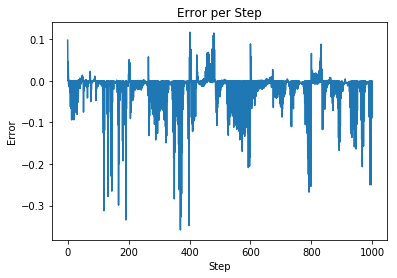

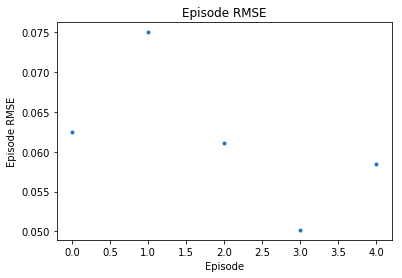

In [101]:
RMSE = np.sqrt(np.mean(np.array(error)**2))
print('RMSE is %r' % RMSE)
print('Mean Error %r' % np.mean(error))
print('Error Standard Deviation %r' % np.std(error))

plt.figure()
plt.plot(error)
plt.xlabel('Step')
plt.ylabel('Error')
plt.title('Error per Step')
plt.figure()
plt.plot(epsd_error, '.')
plt.xlabel('Episode')
plt.ylabel('Episode RMSE')
plt.title('Episode RMSE')
plt.show()

## Digital Input
Now we'll impose the minor constraint on the input that it cannot be represented by a constant signal (eg current, voltage). Our first coding will be a stochastic time-code, in which the signal will be represented by a Poisson distribution firing over multiple time steps. 

In [380]:
model = nengo.Network()

model_layers = {}
with model: 
    for layer, weight in enumerate(discrete_weights):
        no_neuron = weight.shape[1]
        model_layers[layer] = nengo.Ensemble(no_neuron, 
                                             dimensions=no_neuron,
                                             neuron_type = nengo.neurons.TrueNorth(alpha=100.0),
                                             encoders= np.eye(no_neuron),
                                             gain = np.zeros([no_neuron,]) + 1.0,
                                             bias = np.zeros([no_neuron,])
                                                                 )
    model_layers[0].label = 'Layer 1'
    model_layers[1].label = 'Layer 2'
    model_layers[2].label = 'Layer 3' #Not in use 
    
    input_node_pos = nengo.Node(lambda t: np.tile(np.random.binomial(1000, obs_pos/100),4), 
                                size_out=INPUT_DIMS*4)
    input_node_neg = nengo.Node(lambda t: -1.0*np.tile(np.random.binomial(1000, obs_neg/100),4), 
                                size_out=INPUT_DIMS*4)
#     input_node_neg = nengo.Node(lambda t: -1.0*np.random.binomial(10, obs_neg/100), 
#                                 size_out=INPUT_DIMS*4)
    nengo.Connection(input_node_pos, model_layers[0], 
                     transform=discrete_weights[0].transpose(),
                    synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    nengo.Connection(input_node_neg, model_layers[0], 
                     transform=discrete_weights[0].transpose(),
                    synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    nengo.Connection(model_layers[0].neurons, model_layers[1], 
                     transform=discrete_weights[1].transpose(),
                    synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    nengo.Connection(model_layers[1].neurons, model_layers[2], 
                     transform=discrete_weights[2].transpose(),
                    synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    
    Probe_In_pos = nengo.Probe(input_node_pos, synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    Probe_In_neg = nengo.Probe(input_node_neg)
    Probe_A1 = nengo.Probe(model_layers[2].neurons[0], synapse = 0.01)
    Probe_A2 = nengo.Probe(model_layers[2].neurons[1], synapse = 0.01)
    Probe = nengo.Probe(model_layers[0].neurons)
    Probe_in2 = nengo.Probe(model_layers[1], 'input')
    Spikes_1 = nengo.Probe(model_layers[0].neurons)
    Spikes_2 = nengo.Probe(model_layers[1].neurons, synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    Spikes_3 = nengo.Probe(model_layers[2].neurons)

Building finished in 0:00:01.                                                                       
Simulating finished in 0:00:01.                                                                     
Observation: array([ 0.03174087,  0.04091074,  0.04358669, -0.03006166])
Average input: array([ 0.28 ,  0.39 ,  0.43 , -0.292,  0.28 ,  0.39 ,  0.43 , -0.292,
        0.28 ,  0.39 ,  0.43 , -0.292,  0.28 ,  0.39 ,  0.43 , -0.292])
dnn: array([ 0.56015122,  0.43984881], dtype=float32)
snn: array([ 0.5124974,  0.4875026])


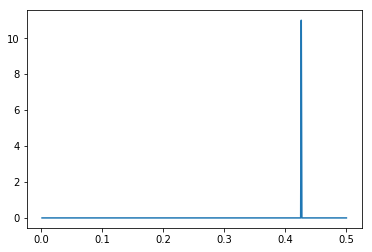

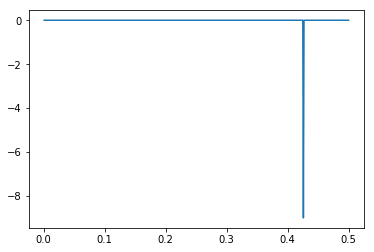

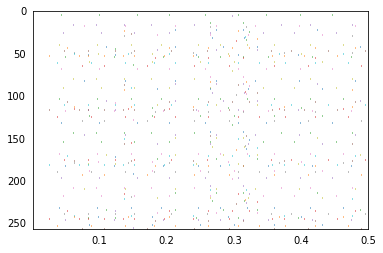

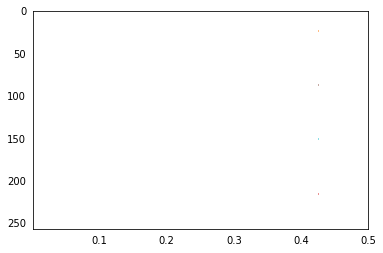

In [389]:
observation = env.reset()
x = observation
z = np.zeros(observation.shape)
obs_pos = np.maximum(x,z)
obs_neg = np.maximum(-1.0*x,z)
feed = {tf_x: np.reshape(x, (1,-1))}
aprob = sess.run(tf_aprob,feed)
dnn_aprob = aprob[0,:]      

T_DIG = 0.5
with nengo.Simulator(model) as sim:
    sim.run(T_DIG)
h_out = sim.data[Spikes_1]
out_enc = sim.data[Spikes_2]
out_dec = np.dot(out_enc,discrete_weights[2])
n = out_dec.shape[0]
# interval = int(T_INT*1000.00*0.7)
# out_1 = out_dec[n-interval:,0].mean()
# out_2 = out_dec[n-interval:,1].mean()
out_1 = out_dec[100:,0].mean()
out_2 = out_dec[100:,1].mean()

snn_aprob = softmax([out_1,out_2])
pos_in = np.mean(sim.data[Probe_In_pos],axis=0)
neg_in = np.mean(sim.data[Probe_In_neg], axis=0)
avg_in = pos_in + neg_in

print('Observation: %r' % observation)
print('Average input: %r' % avg_in)
print('dnn: %r' % dnn_aprob)
print('snn: %r' % snn_aprob)

plt.close()
plt.plot(sim.trange(), out_dec[:,0])

plt.figure()
plt.plot(sim.trange(), out_dec[:,1])

plt.figure()
rasterplot(sim.trange(), h_out)

plt.figure()
rasterplot(sim.trange(), out_enc)

plt.show()

In [390]:
error = []
epsd_error = []
observation_history = []
for epsd in range(N_EPISODES):
    observation = env.reset()
    done = False
    epsd_err = []
    while not done:
        x = observation
        z = np.zeros(observation.shape)
        obs_pos = np.maximum(x,z)
        obs_neg = np.maximum(-1.0*x,z)
        feed = {tf_x: np.reshape(x, (1,-1))}
        obs_max = np.max(np.abs(observation))
        observation_history.append(obs_max)
        aprob = sess.run(tf_aprob,feed)
        dnn_aprob = aprob[0,:]      
        with nengo.Simulator(model) as sim:
            sim.run(T_DIG, progress_bar=False)
        h_out = sim.data[Spikes_1]
        out_enc = sim.data[Spikes_2]
        out_dec = np.dot(out_enc,discrete_weights[2])
        n = out_dec.shape[0]
        out_1 = out_dec[n-100:,0].mean()
        out_2 = out_dec[n-100:,1].mean()
        snn_aprob = softmax([out_1,out_2])
        action = np.random.choice(OUTPUT_DIMS, p=snn_aprob)
        observation, reward, done, info = env.step(action)
        err = dnn_aprob[0]-snn_aprob[0]
        error.append(err)
        epsd_err.append(err)
    if not epsd % 1:
        print('Episode %r complete' % (epsd+1))
    eps_RMSE = np.sqrt(np.mean(np.array(epsd_err)**2))
    epsd_error.append(eps_RMSE)

Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                                       
Building finished in 0:00:01.                                                              

RMSE is 0.083934377966246698
Mean Error -0.022336449675553875
Error Standard Deviation 0.080907742648477152


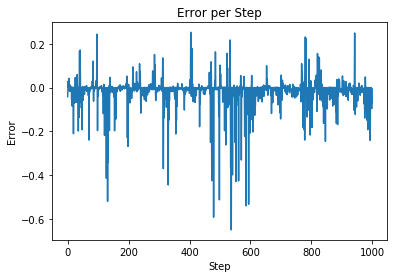

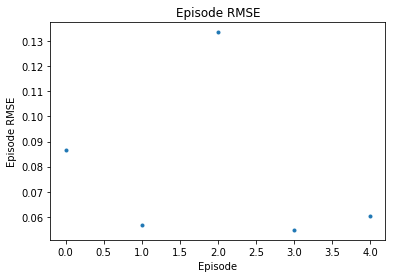

In [391]:
RMSE = np.sqrt(np.mean(np.array(error)**2))
print('RMSE is %r' % RMSE)
print('Mean Error %r' % np.mean(error))
print('Error Standard Deviation %r' % np.std(error))

plt.figure()
plt.plot(error)
plt.xlabel('Step')
plt.ylabel('Error')
plt.title('Error per Step')
plt.figure()
plt.plot(epsd_error, '.')
plt.xlabel('Episode')
plt.ylabel('Episode RMSE')
plt.title('Episode RMSE')
# plt.figure()
# plt.plot(observation_history[1:], error, '.')
plt.show()
# len(observation_history)